# Aggregated Classification Pipelines: Propagating Probabilistic Assumptions from Start to Finish


[Katherine A. Keith](https://kakeith.github.io/)

NLP+CSS 201 Tutorial Series

March 30, 2022 

# Background and motivation 

For background and motivation, see [these slides](). 

**High level goals of this notebook**: 
1. Understand a real-world social science research study that has an “aggregated supervised classification pipeline”
1. Soften (make probabilistic) aspects of this pipeline 
1. Be able to make slight modifications to “off-the-shelf” codebases (huggingface, sklearn) 

**Running example:** We will use the pipeline and data from [Brady et al., "How social learning amplifies moral outrage expression in online social networks," Science Advances, 2021](https://www.science.org/doi/10.1126/sciadv.abe5641), Study 1. 

Although we use this paper as a running example, we note that this framework can be used for many different scenarios. 

Here's a schematic for their pipeline: 
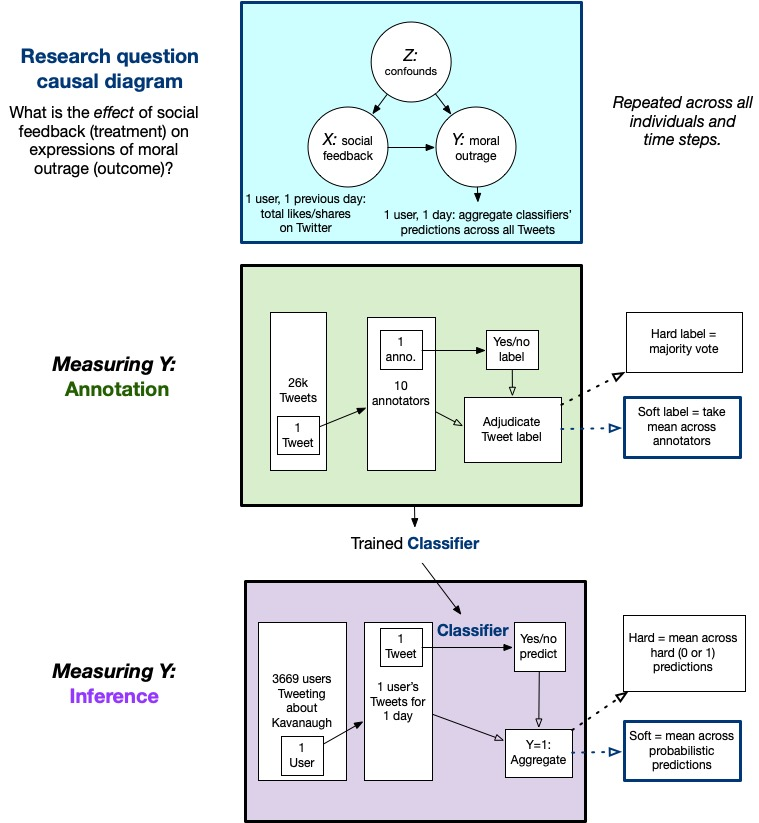

This tutorial builds upon previous tutorials in the [NLP+CSS 201 series](https://nlp-css-201-tutorials.github.io/nlp-css-201-tutorials/). In particular, we recommend revisiting [BERT for Computational Social Scientists](https://youtu.be/UmyOhl9AciI) and [Preprocessing Social Media Text](https://www.youtube.com/watch?v=o5XbbZt7oWs). 

# Code set-up 

In [ ]:
# install necessary packages with pip 
# we'll use version numbers to make sure the subsequent code stays intact  
! pip install emoji==1.7.0 torch==1.11.0 transformers==4.17.0 pandas==1.3.3 numpy==1.21.2
! pip install scikit-learn==1.0.2

In [ ]:
# import packages
import subprocess
import json 
import pandas as pd
import numpy as np 
import torch
from transformers import AutoTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.calibration import CalibrationDisplay, calibration_curve
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# (1) Annotations: inspect and adjudicate

### Load data from Brady et al. 

In [ ]:
# Brady et al. provided us with their original annotations 
# we rehydrated the Tweets 
# we do not share the TweetIds to protect user's privacy 
# we only take a sample of the data to make this tutorial fast (the results will not be representatitve or accurate) 
data_url = "https://raw.githubusercontent.com/kakeith/tutorial9-uncertainty-classification-nlpcss201-2022/main/data/kavanaugh_clean.csv"
df = pd.read_csv(data_url)

In [ ]:
# Brady et al. gathered anntotations from 10 annotators (5 liberal, 5 conservative)
# "con1" indicates conservative annotator #1 
# "lib5" indicates liberal annotator #5
df.head()

,text,con1,con2,con3,con4,con5,lib1,lib2,lib3,lib4,lib5
0,@SenBlumenthal #kavanaugh #fairness. #swamp. ...,1,1,1,1,1,1,1,1,1,1
1,@KatiePavlich @SenBlumenthal He lied about his...,1,1,0,1,0,1,0,0,0,0
2,@SenBlumenthal Why do u believe Dr Ford &amp; ...,0,1,1,0,1,0,0,1,0,1
3,@KatiePavlich @SenBlumenthal Well for starters...,1,1,1,0,1,1,0,1,0,1
4,If you push Brett Kavanaugh through without an...,1,1,1,1,1,1,1,1,1,1


**Annotation assumptions we will use:** 
1. Annotators are not spammers 
1. Annotators' own judgement are calibrated (0 or 1 means the same to everyone) 
1. Disagreement is an inherently useful signal


**301+ Extensions:** Other work has dealt with dealing with adversarial annotators and correcting for annotator bias simultaneously while trying to decide on a correct label. See: 
- [Uma et al. Learning from Disagreement: A Survey. JAIR, 2021.](https://www.jair.org/index.php/jair/article/view/12752)
- *CrowdTruth*. [Aroyo and Welty. 2015. Truth is a lie: Crowd truth and the seven myths of human annotation. AI Magazine, 2015.](https://ojs.aaai.org/index.php/aimagazine/article/view/2564)
- *MACE.* [Hovy et al. Learning whom to trust with MACE. NAACL, 2013.](https://aclanthology.org/N13-1132.pdf)   

### Adjudication approaches 
1. `y_hard` = hard labels (majority vote) 
2. `y_soft` = soft labels (average across all annotators) 

In [ ]:
# names of the columns that are the annotations
col_names = ['con'+str(x) for x in range(1, 6)]+['lib'+str(x) for x in range(1, 6)]

In [ ]:
# soft label = mean 
df['y_soft'] = df[col_names].mean(axis=1) 

In [ ]:
# hard label = majority vote 
df['y_hard'] = np.array((df['y_soft'] >= 0.5).values).astype(int)

In [ ]:
df.head()

,text,con1,con2,con3,con4,con5,lib1,lib2,lib3,lib4,lib5,y_soft,y_hard
0,@SenBlumenthal #kavanaugh #fairness. #swamp. ...,1,1,1,1,1,1,1,1,1,1,1.0,1
1,@KatiePavlich @SenBlumenthal He lied about his...,1,1,0,1,0,1,0,0,0,0,0.4,0
2,@SenBlumenthal Why do u believe Dr Ford &amp; ...,0,1,1,0,1,0,0,1,0,1,0.5,1
3,@KatiePavlich @SenBlumenthal Well for starters...,1,1,1,0,1,1,0,1,0,1,0.7,1
4,If you push Brett Kavanaugh through without an...,1,1,1,1,1,1,1,1,1,1,1.0,1


In [ ]:
# basic dataset statistics 
print('mean y_soft=', np.mean(df['y_soft']))
print('mean y_hard=', np.mean(df['y_hard']))

mean y_soft= 0.5335294117647057
mean y_hard= 0.6


### Manually inspect items with disagreement

Brady et al. define **moral outrage** as: 
"A person can be viewed as expressing moral outrage if: 
1. They have feelings in response to a perceived violation of their personal morals
2. Their feelings are comprised of emotions such as anger, disgust and contempt
3. The feelings are associated with specific reactions including blaming people/events/things, holding them responsible, or wanting to punish them."

In [ ]:
#let's look at the Tweets with a soft label =0.5, meaning the annotators fully disagree
ambiguous = df.loc[df['y_soft']==0.5]

In [ ]:
# #print all ambiguous Tweets
# for i, x in ambiguous.iterrows(): 
#     print(x['text'])
#     print()

I manully pulled out some of the ambiguous texts from the previous cell we can look at: 

- @SenBlumenthal You could be setting up the clean up of all the garbage along Route 91 instead. Wait that would take some effort!
  - *Notes: Sarcasm? Difficult to interpret*
- @nytimes @maureendowd Typical liberal thinking
\#LiberalismIsADesease
  - *Notes: Seems to express contempt with the hashtag. But difficult to say if this fits the definions. 


**Key point:** Text data is different from other forms of data in that we can (and should) pause at various points along a data pipeline and manually evaluate the current outputs. 

# (2) Train classifiers and evaluate performance
**Two approaches to training:** 
1. Hard prediction = BERTweet + NLLLoss + Hard labels 
2. Soft prediction = BERTweet + "Soft Loss" (Cross Entropy + Soft labels) 



### Loss function intutions (with toy data) 

In training a classifier, our goal is to minimize the loss function. For binary classification, both *negative log likelihood* and *cross entropy* losses take the form: 
$$ \text{Loss}(y, p) = - \sum_{i=1}^N y_i \log (p_i) + (1-y_i) \log ({1-p_i})$$
where $y$ are our labels and $p$ are the predicted labels. 

**Soft loss:** Ideally, we would like to take our soft annotation labels (mean over all annotations) as $y$, the "ground truth" against which we evaluate our predictions. 

See: 
- [Peterson et al. Human uncertainty makes classification more robust. ICCV, 2019.](https://openaccess.thecvf.com/content_ICCV_2019/html/Peterson_Human_Uncertainty_Makes_Classification_More_Robust_ICCV_2019_paper.html) Show improved generalization performance with the soft loss and soft labels in computer vision.
- [Uma et al. Learning from Disagreement: A Survey. JAIR, 2021.](https://www.jair.org/index.php/jair/article/view/12752) Compare this soft loss approach to others and place it in context of a broader review. 



However, most native implementations of NLLLoss (e.g. BERT-variatnts) neccessitate that `y` be integers (not real-valued). We will modify these loss functions to accompany a soft loss. 


**Pytorch Loss Implementation Notes:**

---
Binary-class
- `BCEWithLogistsLoss` (sigmoid/softmax applied w/i loss function)
- `BCELoss` (takes probabilitiy inputs, YOU need to sigmoid/softmax) 

--- 
Multi-class 
- `CrossEntropyLoss` (softmax applied w/i loss function)
- `NLLLoss` (takes probabilitiy inputs, YOU apply softmax yourself beforehand to create $p_i$) 
---

In [ ]:
### create toy data 

n_docs = 5 #number of documents
n_ann = 4 #number of annotators 

#annotations for each doc by the human annotators 
prob_y_humans = np.array([[0, 0, 1, 0],
                          [1, 1, 1, 1],
                          [0, 0, 0, 0],
                          [0, 1, 0, 1],
                          [1, 1, 0, 1]])
assert prob_y_humans.shape == (n_docs, n_ann)

# create toy data that could have come out of a model 
# for each document, this indicates the probability of 
# prediciting the postive class (e.g. 'moral outrage')

#INTUITION: models have the same hard predictions, but different soft predictdions

#model 1 
prob_y_model1 = np.array([0.4, 
                        0.6, #prediction correct
                        0.99,
                        0.9, #prediction incorrect 
                        0.2] #prediction incorrect 
                        )  
assert prob_y_model1.shape == (n_docs,)

#model 2
prob_y_model2 = np.array([0.4, 
                          0.9, #prediction MORE corect
                          0.99,
                          0.55, #prediction LESS incorrect 
                          0.45] #prediction LESS incorrect
                          )
assert prob_y_model2.shape == (n_docs,)

#create soft label 
soft_label = np.mean(prob_y_humans, axis=1)

#create hard label 
hard_label = (soft_label >= 0.5).astype(int)

In [ ]:
print('Visualize data')
print('==='*10)
print('{0:<20} {1}'.format('hard labels:',str(list(hard_label))))
print('{0:<20} {1}'.format('soft labels:', str(list(soft_label))))
print('{0:<20} {1}'.format('model1 pred_probs:', str(list(prob_y_model1))))
print('{0:<20} {1}'.format('model2 pred_probs:', str(list(prob_y_model2))))

Visualize data
hard labels:         [0, 1, 0, 0, 1]
soft labels:         [0.25, 1.0, 0.0, 0.5, 0.75]
model1 pred_probs:   [0.4, 0.6, 0.99, 0.9, 0.2]
model2 pred_probs:   [0.4, 0.9, 0.99, 0.55, 0.45]


In [ ]:
#cast into tensors for pytorch 
soft_label = torch.tensor(soft_label).double()
hard_label =  torch.tensor(hard_label).double()
prob_y_model1 = torch.tensor(prob_y_model1)
prob_y_model2 = torch.tensor(prob_y_model2)

In [ ]:
#evaluate loss values (remember: we want to MINIMIZE loss so lower is better) 
loss = torch.nn.BCELoss()
print('Model=1, Gold_Labels=Hard, Loss=', loss(prob_y_model1, hard_label).numpy())
print('Model=2, Gold_Labels=Hard, Loss=', loss(prob_y_model2, hard_label).numpy())
print()
print('Model=1, Gold_Labels=Soft, Loss=', loss(prob_y_model1, soft_label).numpy())
print('Model=2, Gold_Labels=Soft, Loss=', loss(prob_y_model2, soft_label).numpy())
print()

Model=1, Gold_Labels=Hard, Loss= 1.9077688877896435
Model=2, Gold_Labels=Hard, Loss= 1.3636743435694902

Model=1, Gold_Labels=Soft, Loss= 1.6390049674054352
Model=2, Gold_Labels=Soft, Loss= 1.3538469946555758



**Takeaways** 
- When the gold labels are soft both models have lower losses. 
- Even though Models 1 and 2 would give the same hard label predictions, because the soft predictions of Model 2 are better than Model 1, the losses are lower in both settings. 

### Set-up BERTweet Pipeline

We will use the [BERTweet model](https://huggingface.co/vinai/bertweet-base) from huggingface which was described in [Nguyen et al. BERTweet: A pre-trained language model for English Tweets. EMNLP, 2020.](https://aclanthology.org/2020.emnlp-demos.2.pdf). This model pre-trains via the RoBERTa training procedure on 80GB
corpus of 850M English Tweets. 

**Baseline comparisons:** For a real project, you should compare any sophisticated feature representation (e.g. BERT and variants) with a simple BOW representation with logistic regression. However, we will not show this in our tutorial. 

In [ ]:
#load the tokenizer, this does Tweet normalization (emojis to strings, special tokens for URLs and user mentions etc.)
tokenizer_bertweet = AutoTokenizer.from_pretrained("vinai/bertweet-base", normalization=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
#create custom dataset (standard) 
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

#when passing in the soft labels 
class MyDatasetSoft(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, soft_labels):
        self.encodings = encodings
        self.labels = labels
        self.soft_labels = soft_labels #this is custom! 

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        item['soft_labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

In [ ]:
#create train, validation split
prop_validation = 0.2 #proportion of the corpus for validation 
prop_train = 1- prop_validation
num_train = int(np.floor(len(df)*prop_train))


all_inds = np.arange(len(df))

# #shuffle the indices 
# np.random.shuffle(all_inds)

# get slices 
train_inds = all_inds[0:num_train]
val_inds = all_inds[num_train:]
assert len(train_inds) + len(val_inds) == len(df)
print('total exs=', len(df))
print('num train=', len(train_inds))
print('num val=', len(val_inds))

total exs= 340
num train= 272
num val= 68


In [ ]:
#gather the texts 
texts = df['text'].values

#split train and val
train_texts = texts[train_inds]
val_texts = texts[val_inds]

# use BERTweet tokenizer 
# this does the padding for us (shouldn't need to truncate but use this if have longer texts)
train_encondings = tokenizer_bertweet(list(train_texts), truncation=True, padding=True, max_length=512)
val_encondings = tokenizer_bertweet(list(val_texts), truncation=True, padding=True, max_length=512)
print('train after encodings size=', np.array(train_encondings['input_ids']).shape)
print('val after encodings size=', np.array(val_encondings['input_ids']).shape)

train after encodings size= (272, 67)
val after encodings size= (68, 70)


In [ ]:
#gather labels 
y_hard = df['y_hard'].values
y_soft = df['y_soft'].values

#split train and val
train_y_hard = y_hard[train_inds]
train_y_soft = y_soft[train_inds]

assert len(train_y_hard) == len(train_y_soft) == len(train_encondings['input_ids'])

val_y_hard = y_hard[val_inds]
val_y_soft = y_soft[val_inds]

assert len(val_y_hard) == len(val_y_soft) == len(val_encondings['input_ids'])

In [ ]:
#look at the mean labels across these splits 
print('train_y_hard, mean=', np.mean(train_y_hard))
print('train_y_soft, mean=', np.mean(train_y_soft))
print('val_y_hard, mean=', np.mean(val_y_hard))
print('val_y_soft, mean=', np.mean(val_y_soft))

train_y_hard, mean= 0.6360294117647058
train_y_soft, mean= 0.5625
val_y_hard, mean= 0.45588235294117646
val_y_soft, mean= 0.4176470588235294


In [ ]:
#we'll try both hard and soft labels for training 
train_data_hard_labels = MyDataset(train_encondings, train_y_hard)
train_data_soft_labels = MyDatasetSoft(train_encondings, train_y_hard, train_y_soft) #still pass in the hard labels b/c the model will expect this

#validation: we want to use the soft labels 
val_data_hard_labels = MyDataset(val_encondings, val_y_hard)
val_data_soft_labels = MyDatasetSoft(val_encondings, val_y_hard, val_y_soft)

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=-1)
    acc = accuracy_score(labels, preds)
    return {
      'mean_predictions': np.mean(preds), #this can help diagnose if your model is predicting all 0's or all 1's 
      'accuracy': acc
    }

In [ ]:
training_args = TrainingArguments(
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=20,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    learning_rate=3e-5,              # initial learning rate for Adam optimizer
    warmup_steps=10,                # number of warmup steps for learning rate scheduler (set lower because of small dataset size)
    weight_decay=0.001,               # strength of weight decay
    output_dir='./results',          # output directory
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,               # number of steps to output logging (set lower because of small dataset size)
    evaluation_strategy='steps',     # evaluate during fine-tuning so that we can see progress
    seed=123
)

**Note:** For your own real applications, you should do a full hyperparameter search and choose the hyperparamaters that give you the best metrics on your validation data. 

### Hard prediction 
Here, this is standard classification with a BERT model. We should not need to modify anything.

In [ ]:
#TODO: are we getting above majority class accuracy at all? 
# might need to tune these params more 

In [ ]:
#load bertTweet
# we need the SequenceClassification head for our classification task 
# from the hugging face documentation: this is "sequence classification/regression head on top (a linear layer on top of the pooled output)"
model_bertweet1 = RobertaForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=2)

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

In [ ]:
trainer_hard = Trainer(
    model=model_bertweet1,                # the instantiated 🤗 Transformers model to be trained
    args=training_args,                   # training arguments, defined above
    train_dataset=train_data_hard_labels, # training dataset
    eval_dataset=val_data_hard_labels,    # evaluation dataset (usually a validation set; here we just send our test set)
    compute_metrics=compute_metrics       # our custom evaluation function 
)

In [ ]:
trainer_hard.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 272
  Num Epochs = 3
  Instantaneous batch size per device = 20
  Total train batch size (w. parallel, distributed & accumulation) = 20
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss,Validation Loss,Mean Predictions,Accuracy
10,0.674200,0.763260,1.000000,0.455882
20,0.631200,0.705603,0.955882,0.500000
30,0.528000,0.691632,0.720588,0.647059
40,0.476900,0.654922,0.676471,0.691176


***** Running Evaluation *****
  Num examples = 68
  Batch size = 20
***** Running Evaluation *****
  Num examples = 68
  Batch size = 20
***** Running Evaluation *****
  Num examples = 68
  Batch size = 20
***** Running Evaluation *****
  Num examples = 68
  Batch size = 20


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=42, training_loss=0.5684064428011576, metrics={'train_runtime': 546.1328, 'train_samples_per_second': 1.494, 'train_steps_per_second': 0.077, 'total_flos': 28095327380160.0, 'train_loss': 0.5684064428011576, 'epoch': 3.0})

In [ ]:
# save model
# trainer_hard.save_model('saved_hard_model')

### Soft prediction 

In [ ]:
# we expect errors we get when passing the soft labels through the standard BERT model 

# trainer_soft_errors = Trainer(
#     model=model_bertweet1,                # the instantiated 🤗 Transformers model to be trained
#     args=training_args,                   # training arguments, defined above
#     train_dataset=train_data_soft_labels, # training dataset
#     eval_dataset=val_data_soft_labels,    # evaluation dataset (usually a validation set; here we just send our test set)
#     compute_metrics=compute_metrics       # our custom evaluation function 
# )

# trainer_soft_errors.train()

In [ ]:
# create custom trainer for the soft loss  
# https://huggingface.co/docs/transformers/main_classes/trainer?highlight=trainer#trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        """
        Binary Loss function 
        """
        # we will evaluate on the soft labels 
        soft_labels = inputs.get("soft_labels").float()
        
        # standard model can't deal with soft labels 
        inputs_copy = inputs.copy()
        del inputs_copy['soft_labels']
        
        # forward pass
        outputs = model(**inputs_copy)
        out_logits = outputs.get("logits") #output before the softmax/logits
        m = torch.nn.Softmax(dim=1) 
        probs = m(out_logits) #make probabilities
        pos_probs = probs[:, 1] #probabilities of the positive class 
        
        # compute custom soft loss 
        loss_fct = torch.nn.BCELoss()
        loss = loss_fct(pos_probs, soft_labels)
        return (loss, outputs) if return_outputs else loss


In [ ]:
#reload bertTweet so starting at the same starting place as trainer_hard
model_bertweet2 = RobertaForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=2)

trainer_soft = CustomTrainer(
    model=model_bertweet2,                  # the instantiated 🤗 Transformers model to be trained
    args=training_args,                     # training arguments, defined above
    train_dataset=train_data_soft_labels,   # training dataset
    eval_dataset=val_data_soft_labels,      # evaluation dataset (usually a validation set; here we just send our test set)
    compute_metrics=compute_metrics         # our custom evaluation function 
)

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.17.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}

loading w

In [ ]:
trainer_soft.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 272
  Num Epochs = 3
  Instantaneous batch size per device = 20
  Total train batch size (w. parallel, distributed & accumulation) = 20
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss,Validation Loss,Mean Predictions,Accuracy
10,0.671200,0.761347,1.000000,0.455882
20,0.623500,0.690660,0.794118,0.602941
30,0.504100,0.697677,0.720588,0.647059
40,0.446100,0.634435,0.676471,0.691176


***** Running Evaluation *****
  Num examples = 68
  Batch size = 20
***** Running Evaluation *****
  Num examples = 68
  Batch size = 20
***** Running Evaluation *****
  Num examples = 68
  Batch size = 20
***** Running Evaluation *****
  Num examples = 68
  Batch size = 20


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=42, training_loss=0.5513261953989664, metrics={'train_runtime': 534.6101, 'train_samples_per_second': 1.526, 'train_steps_per_second': 0.079, 'total_flos': 28095327380160.0, 'train_loss': 0.5513261953989664, 'epoch': 3.0})

In [ ]:
# save model 
# trainer_soft.save_model('saved_soft_model')

### Calibration 

As we will see in the aggregation step, if we have **calibrated** predicted probabilites at inference time, we will have more accurate aggregate measurements.  

A **perfectly calibrated** model will predict probability estimates that are reprepresentive of the true correctness of likelihood. For example, a model predicts a label with 80\% confidence and that label turns out to be true 80\% of the time. 

We can **estimate calibration error** by binning prediction-label pairs, and estimating the root mean squared error (RMSE) averaged across all bins. 

In our pipeline, with the assumption above that disagreement is a useful signal for uncertainty, we would like the probabilites to be calibrated with the **soft labels**. 

Eventually we will end up with calibration plots that look like: 
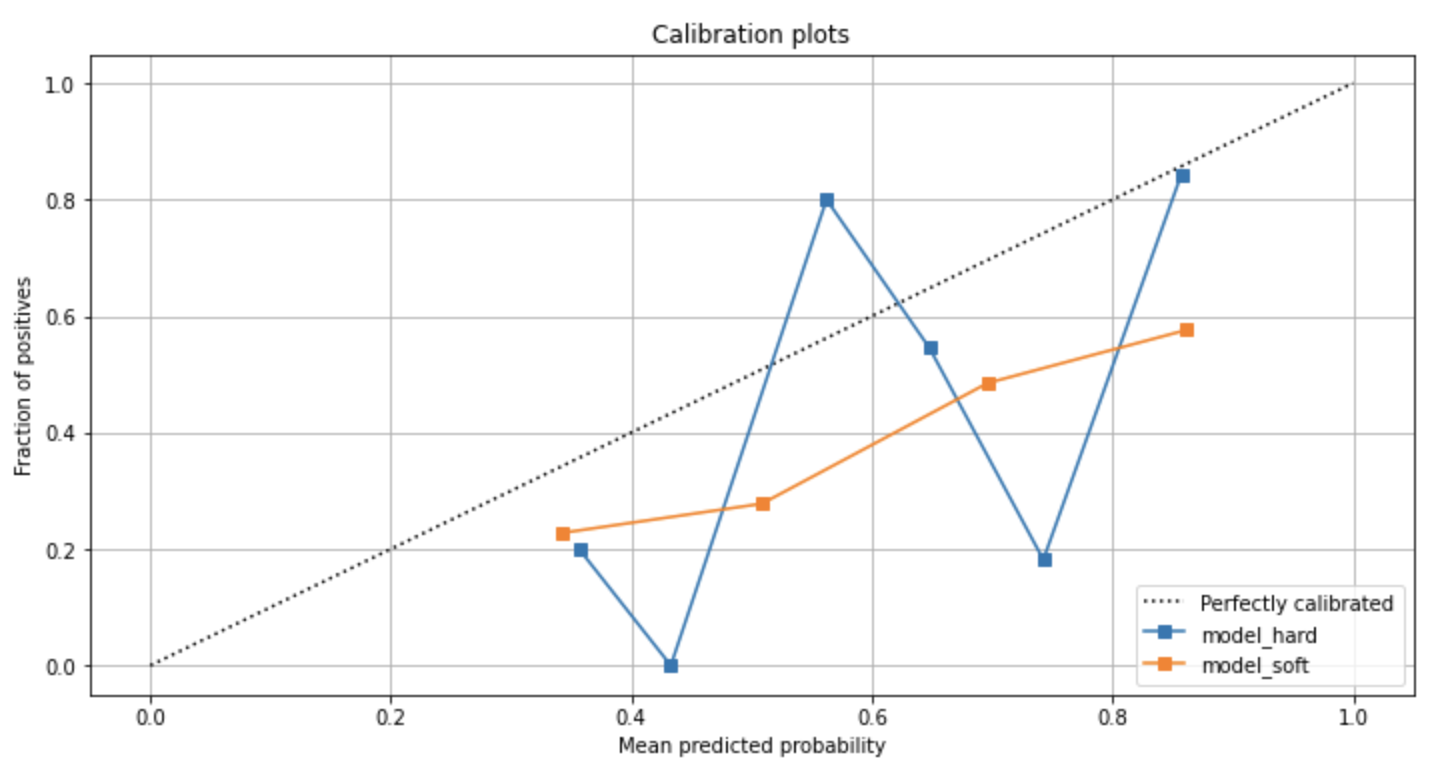

In [ ]:
def logits_to_pos_probs(y_pred):
    """
    Takes the raw output from the model's forward pass, 
    create probabilities of the positive class
    """
    m = torch.nn.Softmax(dim=1) 
    probs = m(torch.tensor(y_pred.predictions)) #make probabilities
    y_pred_pos_probs = probs[:, 1] #probabilities of the positive class
    out = y_pred_pos_probs.detach().numpy()
    assert np.logical_and(0.0 <= out, out <= 1.0).all() 
    return out 

In [ ]:
# model predictions on the validation data 
model_hard_val_y_pred = logits_to_pos_probs(trainer_hard.predict(val_data_hard_labels))
model_soft_val_y_pred = logits_to_pos_probs(trainer_soft.predict(val_data_soft_labels))
assert model_hard_val_y_pred.shape == model_soft_val_y_pred.shape 

#manually check that the model predictions are different 
print('hard model (first 10 preds):', model_hard_val_y_pred[0:10])
print('soft model (first 10 preds):', model_soft_val_y_pred[0:10])

***** Running Prediction *****
  Num examples = 68
  Batch size = 20


***** Running Prediction *****
  Num examples = 68
  Batch size = 20


hard model (first 10 preds): [0.53464025 0.37992403 0.75608826 0.87531066 0.43706304 0.38823712
 0.8799969  0.839817   0.6355606  0.8712236 ]
soft model (first 10 preds): [0.6903869  0.3497639  0.8120536  0.880011   0.3776516  0.36319765
 0.87962353 0.81577915 0.5929548  0.8759159 ]


In [ ]:
# standard sklearn calibration code 

# discretize into uniform bins 
print('model = hard labels, hard loss')
hard_prob_true, hard_prob_pred = calibration_curve(val_y_hard, model_hard_val_y_pred, n_bins=10, strategy='uniform')

#calculate the calibration error 
rms = mean_squared_error(hard_prob_true, hard_prob_pred, squared=False) #False returns RMSE vs MSE 
print('hard model, calibration error = RMSE =', rms)

# # display calibration curve 
# hard_disp = CalibrationDisplay(hard_prob_true, hard_prob_pred, val_y_hard, estimator_name="model_hard")
# hard_disp.plot()

model = hard labels, hard loss
hard model, calibration error = RMSE = 0.3144667097936397


In [ ]:
# #we should see an error when we try to pass our soft labels into the standard sklearn code  
# soft_prob_true, soft_prob_pred = calibration_curve(val_y_soft, model_soft_val_y_pred, n_bins=10, strategy='uniform')

In [ ]:
#so we just need to modify the function that is called within sklearn 
#https://github.com/scikit-learn/scikit-learn/blob/37ac6788c9504ee409b75e5e24ff7d86c90c2ffb/sklearn/calibration.py#L869
def soft_calibration_curve(y_true, y_prob, n_bins=10): 
    """
    Working around when y_true are "soft" labels (not 0's and 1's)

    Only adapting the "uniform" binning strategy 
    """
    bins = np.linspace(0.0, 1.0 + 1e-8, n_bins + 1)
    binids = np.digitize(y_prob, bins) - 1

    bin_sums = np.bincount(binids, weights=y_prob, minlength=len(bins))
    bin_true = np.bincount(binids, weights=y_true, minlength=len(bins))
    bin_total = np.bincount(binids, minlength=len(bins))
    
    nonzero = bin_total != 0
    prob_true = bin_true[nonzero] / bin_total[nonzero]
    prob_pred = bin_sums[nonzero] / bin_total[nonzero]

    return prob_true, prob_pred

In [ ]:
soft_prob_true, soft_prob_pred = soft_calibration_curve(val_y_soft, model_soft_val_y_pred, n_bins=10)

#calculate the calibration error 
rms = mean_squared_error(soft_prob_true, soft_prob_pred, squared=False) #False returns RMSE vs MSE 
print('soft model, calibration error = RMSE =', rms)

# # display calibration curve 
# soft_disp = CalibrationDisplay(soft_prob_true, soft_prob_pred, val_y_hard, estimator_name="model_soft")
# soft_disp.plot()

soft model, calibration error = RMSE = 0.21942932766049814


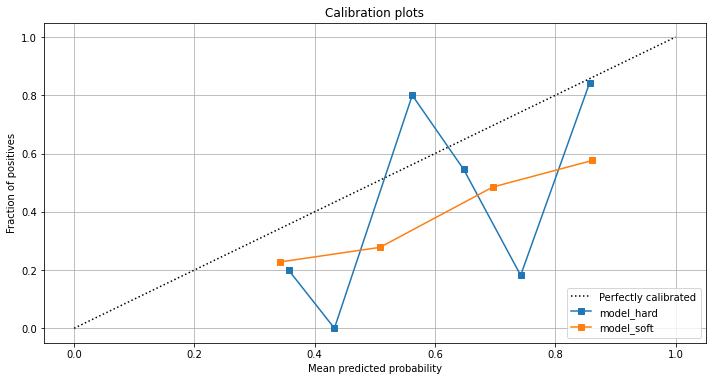

In [ ]:
# show both models on the same plot 
"""
borrow plotting from sklearn 
https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html
"""
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")
ax_calibration_curve = fig.add_subplot(gs[:2, :2])

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

#add the displays
hard_disp = CalibrationDisplay(hard_prob_true, hard_prob_pred, val_y_hard, estimator_name="model_hard") 
soft_disp = CalibrationDisplay(soft_prob_true, soft_prob_pred, val_y_hard, estimator_name="model_soft")
hard_disp.plot(ax=ax_calibration_curve)
soft_disp.plot(ax=ax_calibration_curve)

calibration_displays = {'hard model': hard_disp, 
                        'soft model': soft_disp}
    
plt.tight_layout()
plt.show()

**301+: Calibration extensions**
Popular approaches use *Platt scaling* (or *temperature scaling*) to provide more calibrated probabilistic outputs. This approach trains a separte logistic regression model on top of the model's logits outputs on held-out validation data. See: 
- [Desai and Durrett. Calibration of Pre-trained Transformers. EMNLP, 2020.](https://aclanthology.org/2020.emnlp-main.21/) 
- [Guo et al. On Calibration of Modern Neural Networks. PMLR, 2017.](http://proceedings.mlr.press/v70/guo17a.html)  

Often for NLP tasks, probabilities can be very concentrated around 0 and 1. Other work proposes an "adaptive binning" approach to empirically estimate calibration error that is potentially more accurate for certain NLP applications: 
- [Nguyen and O'Connor. Posterior calibration and exploratory analysis for natural language processing models. EMNLP, 2015.](https://aclanthology.org/D15-1182/) 

Another calbiration approach that cares about aggregating predictions into label proportions selects model hyperparameter based on lowest calibration error on validation data: 
- [Card and Smith. The Importance of Calibration for Estimating Proportions from Annotations. NAACL, 2018.](https://aclanthology.org/N18-1148/) 


# (3) Aggregate predictions at inference time 

### Set-up inference data 
We'll grab the Tweets for one user. 

We're going to use a public figure (celebrity) so as not to imede on regular user's privacy. This deviates from Brady et al. 


In [ ]:
#download file from github
!wget https://raw.githubusercontent.com/kakeith/tutorial9-uncertainty-classification-nlpcss201-2022/main/data/AOC_last100_tweets.json

--2022-03-30 07:51:46--  https://raw.githubusercontent.com/kakeith/tutorial9-uncertainty-classification-nlpcss201-2022/main/data/AOC_last100_tweets.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23905 (23K) [text/plain]
Saving to: ‘AOC_last100_tweets.json.2’

AOC_last100_tweets. 100%[===================>]  23.34K  --.-KB/s    in 0.001s  

2022-03-30 07:51:46 (22.5 MB/s) - ‘AOC_last100_tweets.json.2’ saved [23905/23905]



In [ ]:
#load the file into this notebook 
fname = 'AOC_last100_tweets.json'
with open(fname, 'r') as r: 
  texts = json.load(r)

In [ ]:
print('num tweets = ', len(texts))
print('one tweet text=')
print(texts[0])

num tweets =  100
one tweet text=
When you’re showing off the next book you want banned with the perfect edges and everything to underscore to everyone you haven’t actually read it https://t.co/XNBqBOlxsC


In [ ]:
input_encodings = tokenizer_bertweet(list(texts), truncation=True, padding=True, max_length=512)
bogus_labels = [0 for x in range(len(texts))] #we won't use this but the set-up we have needs us to pass them into the dataset 
one_user_hard = MyDataset(input_encodings, bogus_labels)
one_user_soft = MyDatasetSoft(input_encodings, bogus_labels, bogus_labels)

In [ ]:
def inference_preds(one_user_inference_data, texts, trainer): 
  """
  Returns the positive probabilities from a trained model 
  """
  y_pred_inf = trainer.predict(one_user_inference_data) #these should be before the sigmoid
  pred_pos_prob = logits_to_pos_probs(y_pred_inf)
  assert pred_pos_prob.shape == (len(texts),)
  return pred_pos_prob

In [ ]:
# get the predictions from the trained model 
model2preds = {}

#hard model 
model2preds['hard'] = inference_preds(one_user_hard, texts, trainer_hard)

#soft model 
model2preds['soft'] = inference_preds(one_user_soft, texts, trainer_soft)


***** Running Prediction *****
  Num examples = 100
  Batch size = 20


***** Running Prediction *****
  Num examples = 100
  Batch size = 20


In [ ]:
def print_inferred_moral_outrage(idx, texts, inf_y_pred_pos_prob): 
  print('outrage score=', inf_y_pred_pos_prob[idx])
  print('Tweet=', texts[idx])

In [ ]:
#highest scoring 
argmax = np.argmax(model2preds['hard'])
print_inferred_moral_outrage(argmax, texts, model2preds['hard'])

outrage score= 0.8817385
Tweet= Remember when the right wing had a meltdown when I suggested they exhibit obsessive impulses around young women?

Well now Tucker Carlson is wishing for… this on national TV.

You’re a creep bro. If you’re this easy w/ sexual harassment on air, how are you treating your staff? https://t.co/RFbOIRSmxQ


In [ ]:
#lowest scoring 
argmin = np.argmin(model2preds['hard'])
print_inferred_moral_outrage(argmin, texts, model2preds['hard'])

outrage score= 0.3330008
Tweet= Find it here: https://t.co/K6JXmCH2Vh


### Proportions via aggregating predictions
1. **Hard aggregation** = take the mean across the **predicted hard labels** (0's and 1's). This is called "classify and count (CC)" in the literature. 
2. **Soft aggregation** = take the mean across the **predicted soft labels,** the probability of the positive class (real value between 0 and 1). This is call "probabilistic classify and count (PCC)" in the literature. 

We will also do a **sensitivity analysis** for the steps we took earlier in the pipeline. 


In [ ]:
#hard predictions (predict 0 or 1 rather than probabilities )
def create_hard_predictions(arr): 
  return np.array(arr >= 0.5).astype(int)

model2pred_hard = {}
for model_name in ['hard', 'soft']: 
  model2pred_hard[model_name] = create_hard_predictions(model2preds[model_name])
  print(model2pred_hard[model_name][0:5])

[0 1 1 0 1]
[0 1 1 0 1]


In [ ]:
# final sensitivity analysis 
# A. hard vs. soft models 
# B. hard vs. soft aggregation
print('final sensitivity analysis')
print('==='*10)
print('Hard Model, Hard Aggregation = ', np.mean(model2pred_hard['hard']))
print('Soft Model, Hard Aggregation = ', np.mean(model2pred_hard['soft']))
print()
print('Hard Model, Soft Aggregation =', np.mean(model2preds['hard']))
print('Soft Model, Soft Aggregation =', np.mean(model2preds['soft']))

final sensitivity analysis
Hard Model, Hard Aggregation =  0.73
Soft Model, Hard Aggregation =  0.71

Hard Model, Soft Aggregation = 0.6598799
Soft Model, Soft Aggregation = 0.6429463


**Interpretation of results:** 
- The final inference estimates are sensitive to our hard/soft assumptions throughout the pipeline.
- There is risk in intepretting the hard estimate as AOC being "always outraged" when the soft estimates make this slightly different. 
- In related paper, [Keith et al. 2020 "Uncertainty over Uncertainty: Investigating the Assumptions, Annotations, and Text Measurements of Economic Policy Uncertainty"](https://aclanthology.org/2020.nlpcss-1.13.pdf), we show large variance in estimates from these hard/soft decisions from an economics text-as-data example.

**301+ Extensions for Aggregating Predictions:**
- [Keith and O'Connor. Uncertainty-aware generative models for inferring document class prevalence. EMNLP, 2018.](https://aclanthology.org/D18-1487/) A generative (Bayesian) probabilistic modeling approach to prevalence estimation with the estimation of confidence intervals and extensive empirical evaluation of various approaches. 

# Conclusion 


Recall the initial research question 

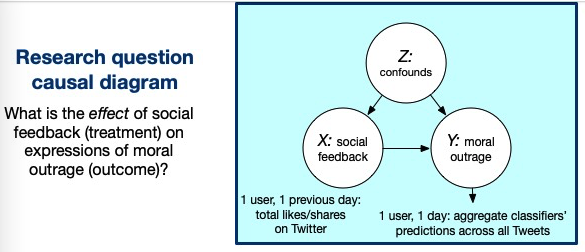

In this notebook we've just focused on the issues of  **measurement.** However, we still haven't inserted these measurements or done sensitity analysis of them as **causal variables**. Everything we have done in this notebook has just been in support of estimating $Y$, one users' aggregate moral outrage. The next step is to insert these estimates of this variable into causal estimation methods. 




Further readings on noisy proxy variables (via machine learning) in causal analyses: 
- [Grimmer, Roberts, and Stewart. Text as Data. MIT Press, 2022.](https://press.princeton.edu/books/hardcover/9780691207544/text-as-data), Chs. 24-27.   
- [Knox et al. Testing Causal Theories with Learned Proxies. ARPS, 2022.](https://www.annualreviews.org/doi/abs/10.1146/annurev-polisci-051120-111443)

**Additional references on the general topic of this tutorial**: 
- [Keith et al. Uncertainty over Uncertainty: Investigating the Assumptions,
Annotations, and Text Measurements of Economic Policy Uncertainty. NLP+CSS Workshop at EMNLP, 2020.](https://aclanthology.org/2020.nlpcss-1.13.pdf)